# Time series classification with Tensorflow & <font color=red>Keras</font> using <font color= #70e514>CNN / ConvNets</font>

## $HAR$ : Humman Activity Recognition

## Example form:

## Time series classification with Tensorflow burakhimmetogluAugust 22, 2017
(https://burakhimmetoglu.com/2017/08/22/time-series-classification-with-tensorflow/)

<img src=https://burakhimmetoglu.files.wordpress.com/2017/08/ekg-158177_640.png height="200" width="260">



* <font size=5 color='green'>[MSTC](http://mstc.ssr.upm.es/big-data-track) seminar on Deep Learning, Tensorflow & Keras</font>



## See Notebooks in GitHub [healthDataScience](https://github.com/healthDataScience)  : $deep-learning-HAR$


![healthDataScience](https://avatars2.githubusercontent.com/u/30838413?s=200&v=4)

In [2]:
! pip install --upgrade tqdm

try:
    from tqdm import tqdm, tqdm_notebook
except ImportError:
    def tqdm(x, *args, **kwargs):
        return x

Requirement already up-to-date: tqdm in /usr/local/lib/python3.6/dist-packages


In [4]:
! pip install --upgrade keras

    100% |████████████████████████████████| 337kB 1.2MB/s 
    100% |████████████████████████████████| 50.0MB 14kB/s 
Requirement already up-to-date: six>=1.9.0 in /usr/local/lib/python3.6/dist-packages (from keras)
    100% |████████████████████████████████| 256kB 1.4MB/s 
    100% |████████████████████████████████| 12.2MB 63kB/s 
  Running setup.py bdist_wheel for pyyaml ... - \ | / done
  Stored in directory: /content/.cache/pip/wheels/2c/f7/79/13f3a12cd723892437c0cfbde1230ab4d82947ff7b3839a4fc
Successfully built pyyaml
  Found existing installation: numpy 1.14.0
    Uninstalling numpy-1.14.0:
      Successfully uninstalled numpy-1.14.0
  Found existing installation: scipy 0.19.1
    Uninstalling scipy-0.19.1:
      Successfully uninstalled scipy-0.19.1
  Found existing installation: PyYAML 3.11
    Uninstalling PyYAML-3.11:
      Successfully uninstalled PyYAML-3.11


In [5]:
# Imports
import numpy as np
import os

import keras
import math


from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline



Using TensorFlow backend.


## Some UTILITY functions

In [0]:

import pandas as pd 
import numpy as np
import os


def standardize(train, test):
	""" Standardize data """

	# Standardize train and test
	X_train = (train - np.mean(train, axis=0)[None,:,:]) / np.std(train, axis=0)[None,:,:]
	X_test = (test - np.mean(test, axis=0)[None,:,:]) / np.std(test, axis=0)[None,:,:]

	return X_train, X_test

def one_hot(labels, n_class = 6):
	""" One-hot encoding """
	expansion = np.eye(n_class)
	y = expansion[:, labels-1].T
	assert y.shape[1] == n_class, "Wrong number of labels!"

	return y


def get_batches(X, y, batch_size = 100):
	""" Return a generator for batches """
	n_batches = len(X) // batch_size
	X, y = X[:n_batches*batch_size], y[:n_batches*batch_size]

	# Loop over batches and yield
	for b in range(0, len(X), batch_size):
		yield X[b:b+batch_size], y[b:b+batch_size]
	


# Human Activity Recognition (HAR) Dataset
## From: [UCI Repository](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones)



## Reading data already prepared from orignal UCI Dataset from a Shared Google Drive npz file

In [7]:
! pip install googledrivedownloader

In [0]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1VLgB0CK8DjMJ4gstLRC0gA2pVGXy-RYa',
                                    dest_path='./UCI_HAR_Dataset_Drive.npz',
                                    unzip=False)

In [9]:
npzfile = np.load('UCI_HAR_Dataset_Drive.npz')
npzfile.files

X_train=npzfile['arr_0']
X_test=npzfile['arr_1']
labels_train=npzfile['arr_2']
labels_test=npzfile['arr_3']

print('Training data size: ',X_train.shape)
print('Test data size: ',X_test.shape)

print('Training labels size: ',labels_train.shape)
print('Test labels size: ',labels_test.shape)

Training data size:  (7352, 128, 9)
Test data size:  (2947, 128, 9)
Training labels size:  (7352,)
Test labels size:  (2947,)


## Six categories (WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, SITTING, STANDING, LAYING).

[LSTM-Human-Activity-Recognition](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition)

    The sensor signals (accelerometer and gyroscope) were pre-processed by applying noise filters and then sampled in fixed-width sliding windows of 2.56 sec and 50% overlap (128 readings/window). The sensor acceleration signal, which has gravitational and body motion components, was separated using a Butterworth low-pass filter into body acceleration and gravity. The gravitational force is assumed to have only low frequency components, therefore a filter with 0.3 Hz cutoff frequency was used.

## ... see some labels...

WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, SITTING, STANDING, LAYING

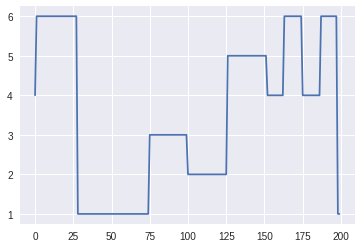

In [0]:
plt.plot(labels_train[50:250])

## ...see some signals...

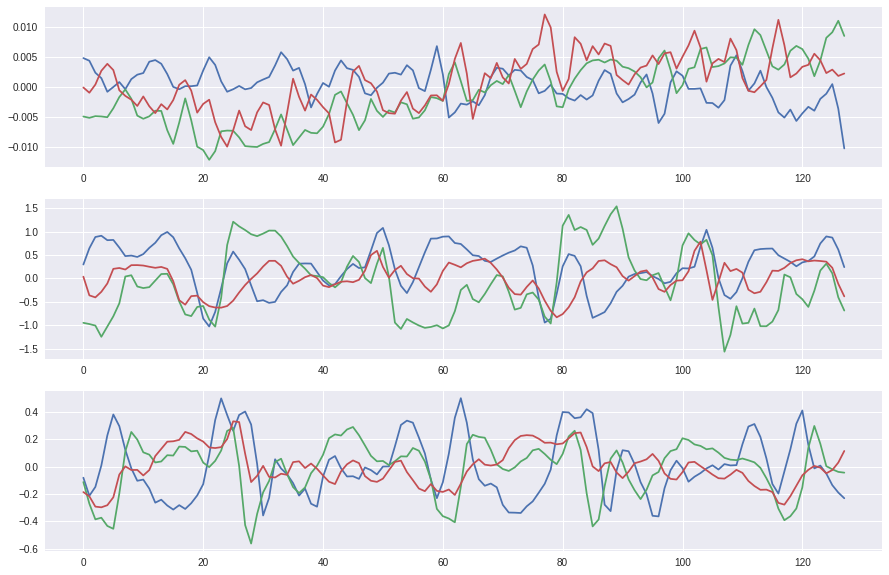

In [0]:
plt.subplots(nrows = 3, figsize = (15, 10), sharex = True)
plt.subplot(3,1,1)
plt.plot(X_train[50,:,0])
plt.plot(X_train[50,:,1])
plt.plot(X_train[50,:,2])

plt.subplot(3,1,2)
plt.plot(X_train[80,:,3])
plt.plot(X_train[80,:,4])
plt.plot(X_train[80,:,5])

plt.subplot(3,1,3)
plt.plot(X_train[110,:,0])
plt.plot(X_train[110,:,1])
plt.plot(X_train[110,:,2])

## One-hot-encoding of Labels

In [0]:
y_train = one_hot(labels_train)
y_test = one_hot(labels_test)

## Re-Shape for 2D Conv (1 D??)

In [14]:
X_train=X_train.reshape([X_train.shape[0],X_train.shape[1],X_train.shape[2],1])
X_test=X_test.reshape([X_test.shape[0],X_test.shape[1],X_test.shape[2],1])

print('Train shape=', X_train.shape , '\nTest shape=', X_test.shape)

Train shape= (7352, 128, 9, 1) 
Test shape= (2947, 128, 9, 1)



## 1.   **Define your ConNet model**:


In [0]:

from keras.models import Sequential

from keras.layers import MaxPooling2D, Dropout, Dense, Flatten

from keras.layers import Convolution2D as Conv2D

model = Sequential()
# input: 128x9 images with 1 channel -> (128, 9) tensors.
# this applies 18 convolution filters of size 2x2 each.
model.add(Conv2D(18, (2, 2), activation='relu', input_shape=(128, 9,1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))

## 2.   **Compile your model**. Specify loss functions and optimizers

In [0]:
from keras.optimizers import SGD


model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True),
              metrics=['accuracy'])

In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 127, 8, 18)        90        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 63, 4, 18)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 63, 4, 18)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 61, 2, 64)         10432     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 1, 64)         0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 30, 1, 64)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1920)              0         
__________

# 3.   **Fit your model**. Train the model using data.

In [21]:
# validation_data allows to see evaluation on test while training
history=model.fit(X_train, y_train,
         epochs=100,
         batch_size=128,
         validation_data=(X_test, y_test),
         verbose=1)

Train on 7352 samples, validate on 2947 samples
Epoch 1/100
7352/7352 [==============================] - 7s 927us/step - loss: 1.2376 - acc: 0.4567 - val_loss: 0.7621 - val_acc: 0.6502
Epoch 2/100
7352/7352 [==============================] - 7s 946us/step - loss: 0.6879 - acc: 0.6685 - val_loss: 0.6522 - val_acc: 0.7099
Epoch 3/100
7352/7352 [==============================] - 7s 948us/step - loss: 0.5632 - acc: 0.7450 - val_loss: 0.6429 - val_acc: 0.7285
Epoch 4/100
3584/7352 [=============>................] - ETA: 3s - loss: 0.5333 - acc: 0.7617

7352/7352 [==============================] - 7s 941us/step - loss: 0.5132 - acc: 0.7750 - val_loss: 0.6341 - val_acc: 0.7465
Epoch 5/100
7352/7352 [==============================] - 7s 944us/step - loss: 0.4708 - acc: 0.8016 - val_loss: 0.6260 - val_acc: 0.7394
Epoch 6/100
7352/7352 [==============================] - 7s 949us/step - loss: 0.4279 - acc: 0.8270 - val_loss: 0.6056 - val_acc: 0.7672
Epoch 7/100
7352/7352 [==============================] - 7s 947us/step - loss: 0.3875 - acc: 0.8483 - val_loss: 0.5384 - val_acc: 0.8252
Epoch 8/100
7168/7352 [============================>.] - ETA: 0s - loss: 0.3386 - acc: 0.8651

7352/7352 [==============================] - 7s 945us/step - loss: 0.3387 - acc: 0.8662 - val_loss: 0.5026 - val_acc: 0.8429
Epoch 9/100
7352/7352 [==============================] - 7s 947us/step - loss: 0.3128 - acc: 0.8808 - val_loss: 0.5162 - val_acc: 0.8446
Epoch 10/100
7352/7352 [==============================] - 7s 955us/step - loss: 0.2785 - acc: 0.8923 - val_loss: 0.4800 - val_acc: 0.8609
Epoch 11/100
7352/7352 [==============================] - 7s 943us/step - loss: 0.2541 - acc: 0.9038 - val_loss: 0.4946 - val_acc: 0.8592
Epoch 12/100
7352/7352 [==============================] - 7s 948us/step - loss: 0.2283 - acc: 0.9100 - val_loss: 0.4561 - val_acc: 0.8663
Epoch 13/100
 128/7352 [..............................] - ETA: 6s - loss: 0.1847 - acc: 0.9062

7352/7352 [==============================] - 7s 943us/step - loss: 0.2084 - acc: 0.9183 - val_loss: 0.4391 - val_acc: 0.8775
Epoch 14/100
7352/7352 [==============================] - 7s 936us/step - loss: 0.2003 - acc: 0.9218 - val_loss: 0.4167 - val_acc: 0.8789
Epoch 15/100
7352/7352 [==============================] - 7s 943us/step - loss: 0.1898 - acc: 0.9264 - val_loss: 0.4664 - val_acc: 0.8809
Epoch 16/100
7352/7352 [==============================] - 7s 944us/step - loss: 0.1832 - acc: 0.9302 - val_loss: 0.4263 - val_acc: 0.8880
Epoch 17/100
6656/7352 [==========================>...] - ETA: 0s - loss: 0.1670 - acc: 0.9366

7352/7352 [==============================] - 7s 942us/step - loss: 0.1675 - acc: 0.9370 - val_loss: 0.4673 - val_acc: 0.8802
Epoch 18/100
7352/7352 [==============================] - 7s 943us/step - loss: 0.1683 - acc: 0.9336 - val_loss: 0.4511 - val_acc: 0.8731
Epoch 19/100
7352/7352 [==============================] - 7s 941us/step - loss: 0.1612 - acc: 0.9372 - val_loss: 0.4400 - val_acc: 0.8853
Epoch 20/100
7352/7352 [==============================] - 7s 934us/step - loss: 0.1589 - acc: 0.9377 - val_loss: 0.5347 - val_acc: 0.8524
Epoch 21/100
7352/7352 [==============================] - 7s 942us/step - loss: 0.1603 - acc: 0.9339 - val_loss: 0.4083 - val_acc: 0.8867


Epoch 22/100
7352/7352 [==============================] - 7s 939us/step - loss: 0.1521 - acc: 0.9403 - val_loss: 0.4538 - val_acc: 0.8880
Epoch 23/100
7352/7352 [==============================] - 7s 934us/step - loss: 0.1455 - acc: 0.9436 - val_loss: 0.4214 - val_acc: 0.8785
Epoch 24/100
7352/7352 [==============================] - 7s 933us/step - loss: 0.1428 - acc: 0.9421 - val_loss: 0.4319 - val_acc: 0.8907
Epoch 25/100
7352/7352 [==============================] - 7s 953us/step - loss: 0.1396 - acc: 0.9433 - val_loss: 0.4474 - val_acc: 0.8850
Epoch 26/100
5888/7352 [=======================>......] - ETA: 1s - loss: 0.1356 - acc: 0.9480

7352/7352 [==============================] - 7s 947us/step - loss: 0.1340 - acc: 0.9478 - val_loss: 0.4526 - val_acc: 0.8829
Epoch 27/100
7352/7352 [==============================] - 7s 948us/step - loss: 0.1279 - acc: 0.9493 - val_loss: 0.4393 - val_acc: 0.8829
Epoch 28/100
7352/7352 [==============================] - 7s 952us/step - loss: 0.1351 - acc: 0.9450 - val_loss: 0.4408 - val_acc: 0.8911
Epoch 29/100
7352/7352 [==============================] - 7s 944us/step - loss: 0.1284 - acc: 0.9471 - val_loss: 0.4339 - val_acc: 0.8890
Epoch 30/100
7296/7352 [============================>.] - ETA: 0s - loss: 0.1327 - acc: 0.9459

7352/7352 [==============================] - 7s 947us/step - loss: 0.1330 - acc: 0.9459 - val_loss: 0.4552 - val_acc: 0.8823
Epoch 31/100
7352/7352 [==============================] - 7s 946us/step - loss: 0.1299 - acc: 0.9459 - val_loss: 0.4458 - val_acc: 0.8775
Epoch 32/100
7352/7352 [==============================] - 7s 942us/step - loss: 0.1257 - acc: 0.9487 - val_loss: 0.4677 - val_acc: 0.8873
Epoch 33/100
7352/7352 [==============================] - 7s 943us/step - loss: 0.1225 - acc: 0.9512 - val_loss: 0.4353 - val_acc: 0.8904
Epoch 34/100
7352/7352 [==============================] - 7s 946us/step - loss: 0.1232 - acc: 0.9482 - val_loss: 0.4457 - val_acc: 0.9043
Epoch 35/100
 128/7352 [..............................] - ETA: 5s - loss: 0.1262 - acc: 0.9375

7352/7352 [==============================] - 7s 942us/step - loss: 0.1228 - acc: 0.9486 - val_loss: 0.4393 - val_acc: 0.8782
Epoch 36/100
7352/7352 [==============================] - 7s 956us/step - loss: 0.1210 - acc: 0.9510 - val_loss: 0.4503 - val_acc: 0.8809
Epoch 37/100
7352/7352 [==============================] - 7s 944us/step - loss: 0.1180 - acc: 0.9528 - val_loss: 0.4492 - val_acc: 0.8751
Epoch 38/100
7352/7352 [==============================] - 7s 941us/step - loss: 0.1186 - acc: 0.9509 - val_loss: 0.4354 - val_acc: 0.8839
Epoch 39/100
6656/7352 [==========================>...] - ETA: 0s - loss: 0.1166 - acc: 0.9534

7352/7352 [==============================] - 7s 931us/step - loss: 0.1151 - acc: 0.9539 - val_loss: 0.4468 - val_acc: 0.8897
Epoch 40/100
7352/7352 [==============================] - 7s 932us/step - loss: 0.1144 - acc: 0.9517 - val_loss: 0.4365 - val_acc: 0.8880
Epoch 41/100
7352/7352 [==============================] - 7s 939us/step - loss: 0.1170 - acc: 0.9506 - val_loss: 0.4465 - val_acc: 0.8829
Epoch 42/100
7352/7352 [==============================] - 7s 946us/step - loss: 0.1144 - acc: 0.9512 - val_loss: 0.4407 - val_acc: 0.8850
Epoch 43/100
7352/7352 [==============================] - 7s 953us/step - loss: 0.1106 - acc: 0.9542 - val_loss: 0.4865 - val_acc: 0.8554


Epoch 44/100
7352/7352 [==============================] - 7s 939us/step - loss: 0.1164 - acc: 0.9535 - val_loss: 0.4535 - val_acc: 0.8867
Epoch 45/100
7352/7352 [==============================] - 7s 946us/step - loss: 0.1145 - acc: 0.9542 - val_loss: 0.4425 - val_acc: 0.8870
Epoch 46/100
7352/7352 [==============================] - 7s 946us/step - loss: 0.1106 - acc: 0.9540 - val_loss: 0.4587 - val_acc: 0.8850
Epoch 47/100
7352/7352 [==============================] - 7s 955us/step - loss: 0.1108 - acc: 0.9513 - val_loss: 0.4797 - val_acc: 0.8890
Epoch 48/100
5888/7352 [=======================>......] - ETA: 1s - loss: 0.1136 - acc: 0.9519

7352/7352 [==============================] - 7s 942us/step - loss: 0.1114 - acc: 0.9528 - val_loss: 0.4260 - val_acc: 0.8935
Epoch 49/100
7352/7352 [==============================] - 7s 939us/step - loss: 0.1118 - acc: 0.9524 - val_loss: 0.4646 - val_acc: 0.8904
Epoch 50/100
7352/7352 [==============================] - 7s 950us/step - loss: 0.1101 - acc: 0.9562 - val_loss: 0.4517 - val_acc: 0.8890
Epoch 51/100
7352/7352 [==============================] - 7s 943us/step - loss: 0.1089 - acc: 0.9548 - val_loss: 0.5165 - val_acc: 0.8697
Epoch 52/100
7296/7352 [============================>.] - ETA: 0s - loss: 0.1090 - acc: 0.9542

7352/7352 [==============================] - 7s 944us/step - loss: 0.1085 - acc: 0.9544 - val_loss: 0.4602 - val_acc: 0.8843
Epoch 53/100
7352/7352 [==============================] - 7s 986us/step - loss: 0.1050 - acc: 0.9554 - val_loss: 0.4566 - val_acc: 0.8914
Epoch 54/100
7352/7352 [==============================] - 7s 949us/step - loss: 0.1130 - acc: 0.9529 - val_loss: 0.4929 - val_acc: 0.8697
Epoch 55/100
7352/7352 [==============================] - 7s 940us/step - loss: 0.1077 - acc: 0.9548 - val_loss: 0.4495 - val_acc: 0.8880
Epoch 56/100
7352/7352 [==============================] - 7s 943us/step - loss: 0.1001 - acc: 0.9588 - val_loss: 0.4874 - val_acc: 0.9063
Epoch 57/100
 128/7352 [..............................] - ETA: 5s - loss: 0.1464 - acc: 0.9453

7352/7352 [==============================] - 7s 936us/step - loss: 0.1050 - acc: 0.9548 - val_loss: 0.4683 - val_acc: 0.8887
Epoch 58/100
7352/7352 [==============================] - 7s 936us/step - loss: 0.1058 - acc: 0.9558 - val_loss: 0.4832 - val_acc: 0.8887
Epoch 59/100
7352/7352 [==============================] - 7s 943us/step - loss: 0.1058 - acc: 0.9557 - val_loss: 0.4622 - val_acc: 0.8894
Epoch 60/100
7352/7352 [==============================] - 7s 946us/step - loss: 0.1019 - acc: 0.9547 - val_loss: 0.4750 - val_acc: 0.8802
Epoch 61/100
6656/7352 [==========================>...] - ETA: 0s - loss: 0.1076 - acc: 0.9549

7352/7352 [==============================] - 7s 937us/step - loss: 0.1076 - acc: 0.9547 - val_loss: 0.4571 - val_acc: 0.8965
Epoch 62/100
7352/7352 [==============================] - 7s 942us/step - loss: 0.1047 - acc: 0.9553 - val_loss: 0.4493 - val_acc: 0.8985
Epoch 63/100
7352/7352 [==============================] - 7s 939us/step - loss: 0.1048 - acc: 0.9559 - val_loss: 0.4795 - val_acc: 0.8897
Epoch 64/100
7352/7352 [==============================] - 7s 945us/step - loss: 0.1011 - acc: 0.9569 - val_loss: 0.4558 - val_acc: 0.8924
Epoch 65/100
7352/7352 [==============================] - 7s 945us/step - loss: 0.1004 - acc: 0.9576 - val_loss: 0.4980 - val_acc: 0.8948


Epoch 66/100
7352/7352 [==============================] - 7s 942us/step - loss: 0.1017 - acc: 0.9580 - val_loss: 0.4764 - val_acc: 0.9002
Epoch 67/100
7352/7352 [==============================] - 7s 942us/step - loss: 0.1036 - acc: 0.9547 - val_loss: 0.4854 - val_acc: 0.8850
Epoch 68/100
7352/7352 [==============================] - 7s 949us/step - loss: 0.0972 - acc: 0.9580 - val_loss: 0.4767 - val_acc: 0.9019
Epoch 69/100
7352/7352 [==============================] - 7s 957us/step - loss: 0.1002 - acc: 0.9570 - val_loss: 0.4751 - val_acc: 0.8948
Epoch 70/100
5888/7352 [=======================>......] - ETA: 1s - loss: 0.0979 - acc: 0.9587

7352/7352 [==============================] - 7s 952us/step - loss: 0.0983 - acc: 0.9589 - val_loss: 0.4582 - val_acc: 0.8921
Epoch 71/100
7352/7352 [==============================] - 7s 941us/step - loss: 0.1009 - acc: 0.9559 - val_loss: 0.4580 - val_acc: 0.8833
Epoch 72/100
7352/7352 [==============================] - 7s 947us/step - loss: 0.0981 - acc: 0.9573 - val_loss: 0.4608 - val_acc: 0.8955
Epoch 73/100
7352/7352 [==============================] - 7s 949us/step - loss: 0.0990 - acc: 0.9577 - val_loss: 0.4821 - val_acc: 0.8911
Epoch 74/100
7296/7352 [============================>.] - ETA: 0s - loss: 0.0977 - acc: 0.9578

7352/7352 [==============================] - 7s 942us/step - loss: 0.0979 - acc: 0.9576 - val_loss: 0.4877 - val_acc: 0.8999
Epoch 75/100
7352/7352 [==============================] - 7s 938us/step - loss: 0.1000 - acc: 0.9570 - val_loss: 0.4799 - val_acc: 0.8907
Epoch 76/100
7352/7352 [==============================] - 7s 946us/step - loss: 0.0948 - acc: 0.9578 - val_loss: 0.4839 - val_acc: 0.8911
Epoch 77/100
7352/7352 [==============================] - 7s 953us/step - loss: 0.0970 - acc: 0.9606 - val_loss: 0.5001 - val_acc: 0.8968
Epoch 78/100
7352/7352 [==============================] - 7s 951us/step - loss: 0.0922 - acc: 0.9607 - val_loss: 0.5029 - val_acc: 0.8965
Epoch 79/100
 128/7352 [..............................] - ETA: 5s - loss: 0.1085 - acc: 0.9453

7352/7352 [==============================] - 7s 950us/step - loss: 0.0979 - acc: 0.9572 - val_loss: 0.4972 - val_acc: 0.8812
Epoch 80/100
7352/7352 [==============================] - 7s 948us/step - loss: 0.0980 - acc: 0.9567 - val_loss: 0.5368 - val_acc: 0.8911
Epoch 81/100
7352/7352 [==============================] - 7s 952us/step - loss: 0.0926 - acc: 0.9589 - val_loss: 0.5018 - val_acc: 0.8884
Epoch 82/100
7352/7352 [==============================] - 7s 947us/step - loss: 0.0914 - acc: 0.9596 - val_loss: 0.4839 - val_acc: 0.9030
Epoch 83/100
6656/7352 [==========================>...] - ETA: 0s - loss: 0.0954 - acc: 0.9581

7352/7352 [==============================] - 7s 943us/step - loss: 0.0938 - acc: 0.9589 - val_loss: 0.5232 - val_acc: 0.8958
Epoch 84/100
7352/7352 [==============================] - 7s 943us/step - loss: 0.0927 - acc: 0.9599 - val_loss: 0.4834 - val_acc: 0.8928
Epoch 85/100
7352/7352 [==============================] - 7s 946us/step - loss: 0.0932 - acc: 0.9588 - val_loss: 0.5119 - val_acc: 0.8951
Epoch 86/100
7352/7352 [==============================] - 7s 946us/step - loss: 0.0901 - acc: 0.9607 - val_loss: 0.5211 - val_acc: 0.8941
Epoch 87/100
7352/7352 [==============================] - 7s 952us/step - loss: 0.0946 - acc: 0.9589 - val_loss: 0.5357 - val_acc: 0.8941


Epoch 88/100
7352/7352 [==============================] - 7s 948us/step - loss: 0.0921 - acc: 0.9588 - val_loss: 0.5109 - val_acc: 0.8941
Epoch 89/100
7352/7352 [==============================] - 7s 945us/step - loss: 0.0884 - acc: 0.9612 - val_loss: 0.5692 - val_acc: 0.8890
Epoch 90/100
7352/7352 [==============================] - 7s 955us/step - loss: 0.0925 - acc: 0.9604 - val_loss: 0.5288 - val_acc: 0.8904
Epoch 91/100
7352/7352 [==============================] - 7s 943us/step - loss: 0.0896 - acc: 0.9606 - val_loss: 0.5089 - val_acc: 0.9033
Epoch 92/100
5888/7352 [=======================>......] - ETA: 1s - loss: 0.0881 - acc: 0.9630

7352/7352 [==============================] - 7s 946us/step - loss: 0.0904 - acc: 0.9616 - val_loss: 0.6284 - val_acc: 0.8833
Epoch 93/100
7352/7352 [==============================] - 7s 954us/step - loss: 0.0929 - acc: 0.9577 - val_loss: 0.5315 - val_acc: 0.8996
Epoch 94/100
7352/7352 [==============================] - 7s 945us/step - loss: 0.0887 - acc: 0.9595 - val_loss: 0.5478 - val_acc: 0.8867
Epoch 95/100
7352/7352 [==============================] - 7s 947us/step - loss: 0.0923 - acc: 0.9592 - val_loss: 0.5566 - val_acc: 0.8972
Epoch 96/100
7296/7352 [============================>.] - ETA: 0s - loss: 0.0869 - acc: 0.9601

7352/7352 [==============================] - 7s 949us/step - loss: 0.0872 - acc: 0.9601 - val_loss: 0.5486 - val_acc: 0.9067
Epoch 97/100
7352/7352 [==============================] - 7s 950us/step - loss: 0.0903 - acc: 0.9608 - val_loss: 0.5314 - val_acc: 0.8999
Epoch 98/100
7352/7352 [==============================] - 7s 943us/step - loss: 0.0884 - acc: 0.9599 - val_loss: 0.5134 - val_acc: 0.8884
Epoch 99/100
7352/7352 [==============================] - 7s 953us/step - loss: 0.0882 - acc: 0.9611 - val_loss: 0.5813 - val_acc: 0.9016
Epoch 100/100
7352/7352 [==============================] - 7s 953us/step - loss: 0.0861 - acc: 0.9599 - val_loss: 0.5821 - val_acc: 0.9016


## 4.   **Make predictions**. Use the model to generate predictions on new data.

In [22]:
# Check accuracy on train set

loss_train, accuracy_train = model.evaluate(X_train, y_train, batch_size=128)


print('\nTraining Accuracy=', accuracy_train)

# Check accuracy on test set

loss, accuracy = model.evaluate(X_test, y_test, batch_size=128)


print('\nTest Accuracy=', accuracy)

7352/7352 [==============================] - 1s 192us/step

Training Accuracy= 0.9640914036996736
2947/2947 [==============================] - 1s 198us/step

Test Accuracy= 0.9015948422124194


Train Accuracy:  0.96
Test_Accuracy:  0.9


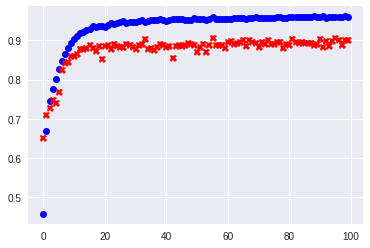

In [23]:
print('Train Accuracy: ',np.round(history.history['acc'][-1],2))
print('Test_Accuracy: ',np.round(history.history['val_acc'][-1],2))

# Plot the accuracy curves
plt.plot(history.history['acc'],'bo')
plt.plot(history.history['val_acc'],'rX')

# Get predictions / probabilities ...

In [24]:
pred_probabilities= model.predict(X_test)

print('First Five Probs.:\n',pred_probabilities[0:5])

print('\n\nFirst Five Classes:\n',y_test[0:5])

First Five Probs.:
 [[2.40959110e-07 1.88856560e-04 3.38605477e-10 1.37776195e-04
  9.99673128e-01 1.84741708e-10]
 [5.23830472e-08 6.45412656e-05 1.52937135e-10 3.16796475e-04
  9.99618530e-01 2.23200639e-10]
 [3.55446694e-08 3.74449883e-05 1.09929364e-10 3.84206272e-04
  9.99578297e-01 1.69051051e-10]
 [3.43276625e-08 2.66618590e-05 7.56342280e-11 3.59829079e-04
  9.99613464e-01 1.36680320e-10]
 [3.72088280e-08 1.56463466e-05 6.67372616e-11 4.53319255e-04
  9.99531031e-01 1.27664906e-10]]


First Five Classes:
 [[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]]


## Confusion Matrix

In [25]:
!pip install pandas_ml

    100% |████████████████████████████████| 81kB 3.5MB/s 
  Running setup.py bdist_wheel for pandas-ml ... - \ done
  Stored in directory: /content/.cache/pip/wheels/13/57/a6/6c0dc8cffa09bb45bfb0b4f88fc13871342bac6a6394784f83
Successfully built pandas-ml


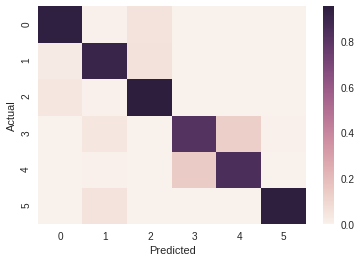

In [27]:
from pandas_ml import ConfusionMatrix

ConfMatrix=ConfusionMatrix(np.argmax(y_test,1), np.argmax(pred_probabilities,1))

ConfMatrix.plot(normalized=True,backend='seaborn')

In [28]:
ConfMatrix.print_stats()

Confusion Matrix:

Predicted    0    1    2    3    4    5  __all__
Actual                                          
0          465    2   29    0    0    0      496
1           14  428   29    0    0    0      471
2           18    2  400    0    0    0      420
3            1   21    0  402   65    2      491
4            0    2    0   77  453    0      532
5            0   28    0    0    0  509      537
__all__    498  483  458  479  518  511     2947


Overall Statistics:

Accuracy: 0.9015948422124194
95% CI: (0.8902689940976302, 0.9121158889805606)
No Information Rate: ToDo
P-Value [Acc > NIR]: 0.0
Kappa: 0.8818392827318308
Mcnemar's Test P-Value: ToDo


Class Statistics:

Classes                                        0          1           2  \
Population                                  2947       2947        2947   
P: Condition positive                        496        471         420   
N: Condition negative                       2451       2476        2527   
Test outcome